## 文本预处理

对于序列数据处理问题，我们在 8.1节中评估了所需的统计⼯具和预测时⾯临的挑战。这样的数据存在许多
种形式，⽂本是最常⻅例⼦之⼀。例如，⼀篇⽂章可以被简单地看作⼀串单词序列，甚⾄是⼀串字符序列。本
节中，我们将解析⽂本的常⻅预处理步骤。这些步骤通常包括：
1. 将⽂本作为字符串加载到内存中。
2. 将字符串拆分为词元（如单词和字符）。
3. 建⽴⼀个词表，将拆分的词元映射到数字索引。
4. 将⽂本转换为数字索引序列，⽅便模型操作。

In [1]:
import collections
import re
from d2l import torch as d2l

### 读取数据集

⾸先，我们从H.G.Well的时光机器 99 中加载⽂本。这是⼀个相当⼩的语料库，只有30000多个单词，但⾜够我
们⼩试⽜⼑，⽽现实中的⽂档集合可能会包含数⼗亿个单词。下⾯的函数将数据集读取到由多条⽂本⾏组成
的列表中，其中每条⽂本⾏都是⼀个字符串。为简单起⻅，我们在这⾥忽略了标点符号和字⺟⼤写。

In [3]:
# @save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

# d2l.read_time_machine()
def read_time_machine(): # @save
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


### 词元化

下⾯的tokenize函数将⽂本⾏列表（lines）作为输⼊，列表中的每个元素是⼀个⽂本序列（如⼀条⽂本⾏）。
每个⽂本序列⼜被拆分成⼀个词元列表，词元（token）是⽂本的基本单位。最后，返回⼀个由词元列表组成
的列表，其中的每个词元都是⼀个字符串（string）。

In [4]:
# d2l.tokenize()
def tokenize(lines, token='word'):
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

In [6]:
tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [7]:
'zhang zhi hui '.split()

['zhang', 'zhi', 'hui']

### 词表

词元的类型是字符串，⽽模型需要的输⼊是数字，因此这种类型不⽅便模型使⽤。现在，让我们构建⼀个字
典，通常也叫做词表（vocabulary），⽤来将字符串类型的词元映射到从0开始的数字索引中。我们先将训练
集中的所有⽂档合并在⼀起，对它们的唯⼀词元进⾏统计，得到的统计结果称之为语料（corpus）。然后根
据每个唯⼀词元的出现频率，为其分配⼀个数字索引。很少出现的词元通常被移除，这可以降低复杂性。另
外，语料库中不存在或已删除的任何词元都将映射到⼀个特定的未知词元(unk)。我们可以选择增加⼀个
列表，⽤于保存那些被保留的词元，例如：填充词元（“(pad)”）；序列开始词元（“(bos)”）；序列结束词元
（“(eos)”）。

In [19]:
# d2l.Vocab()
class Vocab: # @save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        # counter得到的是一个字典
        # 对字典中的值进行排序
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        # 把'<unk>'加到reserved_tokens列表的第一个位置
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx 
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token)-1
                
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    @property
    def unk(self): # 未知词云的索引为0
        return 0
    @property
    def token_freqs(self):
        return self._token_freqs

# d2l.count_corpus()
def count_corpus(tokens): # @save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [20]:
# 我们⾸先使⽤时光机器数据集作为语料库来构建词表，然后打印前⼏个⾼频词元及其索引。
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [21]:
# 现在，我们可以将每⼀条⽂本⾏转换成⼀个数字索引列表。
for i in [0, 10]:
    print('文本：', tokens[i])
    print('索引：', vocab[tokens[i]])

文本： ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引： [1, 19, 50, 40, 2183, 2184, 400]
文本： ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引： [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


### 整合所有功能

在使⽤上述函数时，我们将所有功能打包到load_corpus_time_machine函数中，该函数返回corpus（词元索
引列表）和vocab（时光机器语料库的词表）。我们在这⾥所做的改变是：
1. 为了简化后⾯章节中的训练，我们使⽤字符（⽽不是单词）实现⽂本词元化；
2. 时光机器数据集中的每个⽂本⾏不⼀定是⼀个句⼦或⼀个段落，还可能是⼀个单词，因此返回
的corpus仅处理为单个列表，⽽不是使⽤多词元列表构成的⼀个列表。

In [22]:
# d2l.load_corpus_time_machine()
def load_corpus_time_machine(max_tokens=-1): #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展开到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

In [23]:
corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

In [27]:
vocab.token_to_idx.items()

dict_items([('<unk>', 0), (' ', 1), ('e', 2), ('t', 3), ('a', 4), ('i', 5), ('n', 6), ('o', 7), ('s', 8), ('h', 9), ('r', 10), ('d', 11), ('l', 12), ('m', 13), ('u', 14), ('c', 15), ('f', 16), ('w', 17), ('g', 18), ('y', 19), ('p', 20), ('b', 21), ('v', 22), ('k', 23), ('x', 24), ('z', 25), ('j', 26), ('q', 27)])

⼩结

    • ⽂本是序列数据的⼀种最常⻅的形式之⼀。
    • 为了对⽂本进⾏预处理，我们通常将⽂本拆分为词元，构建词表将词元字符串映射为数字索引，并将⽂本数据转换为词元索引以供模型操作。

## 语言模型和数据集

在 8.2节中，我们了解了如何将⽂本数据映射为词元，以及将这些词元可以视为⼀系列离散的观测，例如单
词或字符。假设⻓度为T的⽂本序列中的词元依次为x 1 ,x 2 ,...,x T 。于是，x t （1 ≤ t ≤ T）可以被认为是⽂
本序列在时间步t处的观测或标签。在给定这样的⽂本序列时，语⾔模型（language model）的⽬标是估计序
列的联合概率
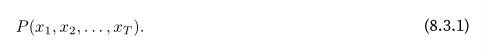
例如，只需要⼀次抽取⼀个词元x t ∼ P(x t | x t−1 ,...,x 1 )，⼀个理想的语⾔模型就能够基于模型本⾝⽣成⾃
然⽂本。与猴⼦使⽤打字机完全不同的是，从这样的模型中提取的⽂本都将作为⾃然语⾔（例如，英语⽂本）
来传递。只需要基于前⾯的对话⽚断中的⽂本，就⾜以⽣成⼀个有意义的对话。显然，我们离设计出这样的
系统还很遥远，因为它需要“理解”⽂本，⽽不仅仅是⽣成语法合理的内容。

尽管如此，语⾔模型依然是⾮常有⽤的。例如，短语“to recognize speech”和“to wreck a nice beach”读
⾳上听起来⾮常相似。这种相似性会导致语⾳识别中的歧义，但是这很容易通过语⾔模型来解决，因为第⼆
句的语义很奇怪。同样，在⽂档摘要⽣成算法中，“狗咬⼈”⽐“⼈咬狗”出现的频率要⾼得多，或者“我想
吃奶奶”是⼀个相当匪夷所思的语句，⽽“我想吃，奶奶”则要正常得多。